# Sleep stages classification pipeline
___

This notebooks aims to construct our feature matrix from our sleep records [sleep-edf](https://physionet.org/content/sleep-edfx/1.0.0/) from _physionet_. 

We will reuse the chosen features from our exploration notebook.

Since all of the dataset cannot be loaded in memory at the same time, we will have to implement a pipeline, where each step can then be run with only one recording at a time. At the end of this notebook, we will be able to concatenate all resulting features in a single matrix.

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from multiprocessing import Pool, cpu_count

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import (FunctionTransformer, StandardScaler)
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (train_test_split, KFold)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score,
                             confusion_matrix,
                             classification_report,
                             f1_score,
                             cohen_kappa_score)

import mne
from mne.time_frequency import psd_welch

from scipy.stats import (skew, kurtosis)
from scipy.signal import butter

from utils import fetch_data
from constants import (SLEEP_STAGES_VALUES,
                       DATASET_SLEEP_STAGES_VALUES,
                       N_STAGES,
                       EEG_CHANNELS, 
                       EPOCH_DURATION,
                       SAMPLING_FREQ)
from models.model_utils import print_hypnogram

We define a few constants.

In [3]:
NB_EPOCHS_AWAKE_MORNING = 60
    
NYQUIST_FREQ = SAMPLING_FREQ/2
MAX_TIME = EPOCH_DURATION - 1. / SAMPLING_FREQ  # tmax in included

# EEG sub bands labels
DELTA = "delta"
THETA = "theta"
ALPHA = "alpha"
SIGMA = "sigma"
BETA = "beta"

FREQ_BANDS_RANGE = {
    DELTA: [0.5, 4.5],
    THETA: [4.5, 8.5],
    ALPHA: [8.5, 11.5],
    SIGMA: [11.5, 15.5],
    BETA: [15.5, 30]
}

FREQ_BANDS_ORDERS = {
    DELTA: 5,
    THETA: 8,
    ALPHA: 9,
    SIGMA: 9,
    BETA: 14
}

## Preprocessing
___

Our dataset consists of 39 recordings, each containing about 20 hours of EEG, EOG, EMG, and other signals, sampled at 100 or 1Hz.

### 1. Loading recordings informations
___

This file contains information about when a recording was started, at which time the subject went to bed and the amount of sleep he got.

In [4]:
df_records = pd.read_csv("data/recordings-info.csv")
df_records.head(5)

,subject,night,age,sex,LightsOff,NightDuration,LightsOffSecond,StartRecord,StartRecordTimestamp
0,0,1,33,1,1989-04-25 00:38:00,21810.0,30300.0,1989-04-24 16:13:00,609437580.0
1,0,2,33,1,1989-04-25 21:57:00,30330.0,25620.0,1989-04-25 14:50:00,609519000.0
2,1,1,33,1,1989-03-29 22:44:00,29250.0,21300.0,1989-03-29 16:49:00,607193340.0
3,1,2,33,1,1989-03-30 22:15:00,31260.0,18900.0,1989-03-30 17:00:00,607280400.0
4,2,1,26,1,1989-04-05 22:50:00,27150.0,21720.0,1989-04-05 16:48:00,607798080.0


We add a new column where we indicate in which age group each subject belongs. They are arbitrarily chosen according to the histogram in order to have the relatively same number of observations among those groups. 

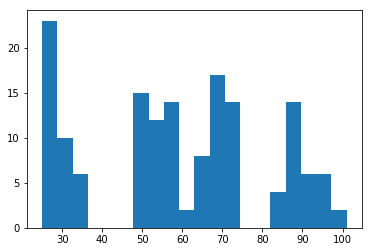

,subject,night,age,sex,LightsOff,NightDuration,LightsOffSecond,StartRecord,StartRecordTimestamp,AgeCategory
0,0,1,33,1,1989-04-25 00:38:00,21810.0,30300.0,1989-04-24 16:13:00,609437580.0,0
1,0,2,33,1,1989-04-25 21:57:00,30330.0,25620.0,1989-04-25 14:50:00,609519000.0,0


In [5]:
plt.hist(df_records['age'], bins=20)
plt.show()

age_groups = [
    [0,49],  # 39 recordings
    [50,59], # 41 recordings
    [60,84], # 41 recordings
    [85,110] # 32 recordings
]

df_records['AgeCategory'] = [None]*len(df_records)
for index, group in enumerate(age_groups):
    df_records.loc[(df_records['age'] >= group[0]) & (df_records['age'] <= group[1]), 'AgeCategory'] = index
    
df_records.head(2)



### 2. Retrieve data from file and filter to only one channel of EEG
___

This step includes:
- Retrieving edf file
- Excluding channels that are not EEG signals
- Retrieving dataframe recordings information

In [6]:
def fetch_signal(psg_file_name, hypno_file_name=None):
    """
    returns: mne.Raw of the whole night recording
    """
    raw_data = mne.io.read_raw_edf(psg_file_name, preload=True, stim_channel=None, verbose=False)
    
    if hypno_file_name is not None:
        annot = mne.read_annotations(hypno_file_name)
        raw_data.set_annotations(annot, emit_warning=False)
    
    return raw_data

def drop_other_channels(raw_data, channel_to_keep):
    """
    returns: mne.Raw with the two EEG channels and the signal
        between the time the subject closed the lights and the time
        at which the subject woke up
    """
    raw_data.drop_channels([ch for ch in raw_data.info['ch_names'] if ch != channel_to_keep])
    
    return raw_data

def get_recording_info(file_name):
    # Each file is named according to this pattern:
    #   SC4ssNEO-PSG.edf where SS is subject index (3:5) and N is subject night index (5:6)
    subject_index = int(file_name[3:5])
    subject_night = int(file_name[5:6])
    
    return df_records[(df_records['subject'] == subject_index) & (df_records['night'] == subject_night)]

In [7]:
get_recording_info("SC4121E0-PSG.edf")

,subject,night,age,sex,LightsOff,NightDuration,LightsOffSecond,StartRecord,StartRecordTimestamp,AgeCategory
24,12,1,26,2,1989-05-23 00:50:00,25050.0,31680.0,1989-05-22 16:02:00,611856120.0,0


### 3. Convert Raw signal to epochs or matrices
___

In [8]:
def crop_raw_data(raw_data, info):
    """
    returns:
        mne.Raw, where we only keep from the lights off to a certain time after the subject woke up.
    """
    # Number of seconds since file began
    closed_lights_time = info['LightsOffSecond'].values[0]
    woke_up_time = closed_lights_time + info['NightDuration'].values[0] + NB_EPOCHS_AWAKE_MORNING*EPOCH_DURATION

    raw_data.crop(tmin=closed_lights_time, tmax=min(woke_up_time, raw_data.times[-1]))

    return raw_data
    
def convert_to_epochs(raw_data, annotations_stage_dict=DATASET_SLEEP_STAGES_VALUES):
    """
    returns:
        mne.Epochs, where the epochs are only choosen if the subject was in bed.
        y: np array of shape (nb_epochs,), which contains each epoch label.
    """
    events, annot_event_id = mne.events_from_annotations(
        raw_data,
        event_id=annotations_stage_dict,
        chunk_duration=EPOCH_DURATION,
        verbose=False)
    
    # Few files do not have N3 sleep (i.e. SC4202EC-Hypnogram), so we have to filter out key-value pairs that are not in the annotations.
    event_id = { 
        event_key: SLEEP_STAGES_VALUES[event_key] 
        for event_key in SLEEP_STAGES_VALUES
        if SLEEP_STAGES_VALUES[event_key] in annot_event_id.values()
    }
    
    epochs = mne.Epochs(
        raw=raw_data,
        events=events,
        event_id=event_id,
        tmin=0.,
        tmax=MAX_TIME,
        preload=True,
        baseline=None,
        verbose=False)
    
    y = np.array([event[-1] for event in epochs.events])
    
    return epochs, y 


def convert_to_matrices(data):
    """
    data: mne.Epochs with only one EEG channel
    
    returns
        - X: Matrix of input values, of size (nb_epochs, sampling_rate*epoch_length=3000)
        - y: Vector of observation labels, of size (nb_epochs,)
    """
    df = data.to_data_frame(picks="eeg", long_format=True)
    df = df.drop(columns=['ch_type', 'channel'])
    df = df.sort_values(by=['epoch', 'time'])
    
    y = df[['epoch', 'condition']].drop_duplicates(keep="first")['condition'].to_numpy()
    X = np.matrix(
        [df[df['epoch'] == epoch]['observation'].to_numpy() for epoch in df['epoch'].unique()]
    )

    return X, y

Complete function to apply in order to preprocess our data:

In [9]:
def preprocess(data, current_channel, df_info, convert_to_matrix=False):
    """
    data: mne.Raw 
        Instance of all of the night recording and all channels
    current_channel: str 
        Current EEG channel
        
    returns
        - X: Matrix of input values, of size (nb_epochs, sampling_rate*epoch_length=3000)
        - y: Vector of observation labels, of size (nb_epochs,)
    """
    data = drop_other_channels(data, current_channel)
    data = crop_raw_data(data, df_info)
    data, y = convert_to_epochs(data)
    
    if not convert_to_matrix:
        return data, y
    
    return convert_to_matrices(data)


## Feature extraction
___


```
        Frequency domain
        features                +----> Average delta band +-+
                +-------+       |                           |
      +-------->+  FFT  +-------+      ...                  |
      |         +-------+       |                           |
      |                         +----> Mean frequency  +----+
      |                                                     |
      |                                                     |
      |                                                     |
  X +-+                                                     +-> X'
Input |                                                     |   Features
mne.  |                         +-----> Variance +----------+   np.array
Epochs|                         |                           |   shape:
      |         +----------+    |                           |    (nb_epochs, nb_features)
      +-------->+ get_data +-------------> Mean +-----------+
                +----------+    |                           |
                                |       ...                 |
                                |                           |
                                +-----> Zero cross rate ----+
                                                            
                                
        Time
        domain features

```

We first have to define a transformer that will extract the values out of an epoch instance. 

The pipeline **cannot fit** to the data it receives, because there will be several call to transform the input data, hence the epochs,  into the feature array. They will be transformed one night recording at a time.

In [10]:
def get_data_from_epochs(epochs):
    """
    epochs: mne.Epochs
    
    returns np array of shape (nb_epochs, sampling_rate*epoch_length)
    """
    return epochs.get_data().squeeze()

get_data_from_epochs_transformer = FunctionTransformer(get_data_from_epochs, validate=False)

We then define a skeleton fonction which receives a fonction that is called for every epochs. 

In [11]:
def get_transformer(get_feature):
    
    def get_one_feature_per_epoch(X, get_feature):
        """
        X: Input matrix (nb_epochs, sampling_rate*epoch_length)
        get_feature: callable 
            generates one feature for each epoch

        returns matrix (nb_epoch,1)
        """
        return [[get_feature(epoch)] for epoch in X]

    return lambda X: get_one_feature_per_epoch(X, get_feature)

def get_transformer_list(get_features):
    
    def get_feature_list_per_epoch(X, get_features):
        """
        X: Input matrix (nb_epochs, sampling_rate*epoch_length)
        get_feature: callable 
            generates a list of features for each epoch

        returns matrix (nb_epoch,nb_features)
        """
        return [get_features(epoch) for epoch in X]

    return lambda X: get_feature_list_per_epoch(X, get_features)

#### 1. Time domain features
___

##### a) Standard statistics
____

We extract features on the distribution of the time domain values of each epoch.

In [12]:
mean_transformer = FunctionTransformer(get_transformer(np.mean), validate=True)
std_transformer = FunctionTransformer(get_transformer(np.std), validate=True)
skew_transformer = FunctionTransformer(get_transformer(skew), validate=True)
kurtosis_transformer = FunctionTransformer(get_transformer(kurtosis), validate=True)

##### b) Mean crossing rate
____

In [13]:
def get_zero_crossing_rate(signal):
    """
    Multiplies signal by itself shifted by one.
    If the signal crosses the horizontal axis, the sign will be negative and vice-versa.
    
    Returns nb of time the signal crossed the horizontal axis
    """
    return ((signal[:-1] * signal[1:]) < 0).sum()

def get_mean_crossing_rate(signal):
    return get_zero_crossing_rate(signal - np.mean(signal))

mean_crossing_rate_transformer = FunctionTransformer(get_transformer(get_mean_crossing_rate), validate=True)

##### c) Hjorth parameters
____

In [14]:
# Code taken from PyEEG: https://github.com/forrestbao/pyeeg

def hjorth(X):
    """ Compute Hjorth mobility and complexity of a time series from either two
    cases below:
        1. X, the time series of type list (default)
        2. D, a first order differential sequence of X (if D is provided,
           recommended to speed up)
    In case 1, D is computed using Numpy's Difference function.
    Notes
    -----
    To speed up, it is recommended to compute D before calling this function
    because D may also be used by other functions whereas computing it here
    again will slow down.
    Parameters
    ----------
    X
        list
        a time series
    D
        list
        first order differential sequence of a time series
    Returns
    -------
    As indicated in return line (mobility, complexity)
    """
    D = np.diff(X)
    D = D.tolist()

    D.insert(0, X[0])  # pad the first difference
    D = np.array(D)

    n = len(X)

    M2 = float(sum(D ** 2)) / n
    TP = sum(np.array(X) ** 2)
    M4 = 0
    for i in range(1, len(D)):
        M4 += (D[i] - D[i - 1]) ** 2
    M4 = M4 / n

    # Hjorth Mobility and Complexity
    mobility = np.sqrt(M2 / TP)
    complexity = np.sqrt(
        float(M4) * TP / M2 / M2
    )
    return [mobility, complexity] # np.concatenate([mobility, complexity], axis=1)

hjorth_transformer = FunctionTransformer(get_transformer_list(hjorth), validate=True)

##### Merging all time domain features with `FeatureUnion`
___

In [15]:
NB_OF_TIME_DOMAIN_FEATURES = 7

In [16]:
time_domain_feature_union = FeatureUnion([
    ('mean', mean_transformer),
    ('std', std_transformer),
    ('skew', skew_transformer),
    ('kurtosis', kurtosis_transformer),
    ('mean-crossing-rate', mean_crossing_rate_transformer),
    ('hjorth', hjorth_transformer)
], n_jobs=1)

time_domain_pipeline = Pipeline([
    ('epochs_to_data', get_data_from_epochs_transformer),
    ('time_domain_features', time_domain_feature_union)
])

#### 2. Frequency domain features
___

In [17]:
def get_psds_from_epochs(epochs):
    """Extracts power spectrum densities from epochs
    Returns
    --------
    psds with associated frequencies calculated with the welch method.
    """
    psds, freqs = psd_welch(epochs, fmin=0.5, fmax=30.)
    return psds, freqs

get_psds_from_epochs_transformer = FunctionTransformer(get_psds_from_epochs, validate=False)

##### a) Absolute and relative mean power for each band
____

In [18]:
def get_mean_psds(psds_with_freqs, are_relative=False):
    """EEG power band feature extraction.
    Input
    -------
    psds_with_freqs: tuple which contains
            - (nb_epochs, nb_chan=1, nb_freqs) psds amplitudes
            - (nb_freqs,) corresponding frequency values
            
    are_relative: boolean which indicates if the mean band powers
        for each subband are relative to the total power or not.
    
    Returns
    -------
    X : numpy array of shape [n_samples, nb_subband=5]
        Transformed data.
    """
    psds = psds_with_freqs[0]
    freqs = psds_with_freqs[1]
    
    if are_relative:
        psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS_RANGE.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

absolute_mean_psds_transformer = FunctionTransformer(get_mean_psds, validate=False)
relative_mean_psds_transformer = FunctionTransformer(lambda psds_with_freq: get_mean_psds(psds_with_freq, are_relative=True), validate=False)

##### b) Spectral edge frequency difference
___


In [19]:
def get_sefd(psd, freqs):
    """Spectral edge frequency difference
    Input
    -------
    psd: array of the power spectrum density for one epoch
    freqs: array of the frequencies
    
    Returns
    -------
    Difference between the frequencies under which cumulates 95 and 50 percent of the power
    """
    assert len(psd) == len(freqs), "All PSD value must have a corresponding frequency value"
    
    CUMUL_POWER_RATIO = [0.50, 0.95]

    total_power = np.sum(psd)
    cumul_power = 0

    lower_freq = None
    upper_freq = None
    
    for amp, freq in zip(psd, freqs):
        cumul_power += amp
        if cumul_power >= CUMUL_POWER_RATIO[1] * total_power:
            upper_freq = freq
            break
        elif lower_freq is None and cumul_power >= CUMUL_POWER_RATIO[0] * total_power:
            lower_freq = freq

    return upper_freq - lower_freq


def get_sefd_on_all_epochs(psds_with_freqs):
    """SEFd on all epochs
    """
    SUBBAND_FREQ_SEFD = [8., 16.]

    psds = psds_with_freqs[0].squeeze()
    freqs = psds_with_freqs[1]
    
    psds = psds[:, (freqs >= SUBBAND_FREQ_SEFD[0]) & (freqs < SUBBAND_FREQ_SEFD[1])]
    freqs = freqs[(freqs >= SUBBAND_FREQ_SEFD[0]) & (freqs < SUBBAND_FREQ_SEFD[1])]
    
    return [[get_sefd(one_epoch_psd, freqs)] for one_epoch_psd in psds]

sefd_transformer = FunctionTransformer(get_sefd_on_all_epochs, validate=False)

##### Merging all frequency domain features with `FeatureUnion`
___

In [20]:
NB_OF_FREQUENCY_DOMAIN_FEATURES = 2 * len(FREQ_BANDS_RANGE) + 1

In [21]:
frequency_domain_feature_union = FeatureUnion([
    ('absolute_mean_power_band', absolute_mean_psds_transformer),
    ('relative_mean_power_band', relative_mean_psds_transformer),
    ('sefd', sefd_transformer)
], n_jobs=1)

frequency_domain_pipeline = Pipeline([
    ('get_psds_from_epochs', get_psds_from_epochs_transformer),
    ('frequency_domain_features', frequency_domain_feature_union)
])

#### 3. Sub-band features
___

Certain features discriminate more sleep stages when they are calculated only on a particular sub-band. We will provide functions which calculates the value on each sub-band, and then divide the signal before calling these functions.

##### a) Mean energy
___

Mean energy corresponds to $ME = \frac{1}{N}\sum_{t=0}^{N} x_t^2$, where N is the epoch length.

In [22]:
def get_signal_mean_energy(signal):
    """
    signal: array of (nb_sample_per_epoch,)
    """
    return np.sum(signal**2)*1e6

mean_energy_transformer = FunctionTransformer(get_transformer(get_signal_mean_energy), validate=True)

We will apply 5 IIR filters on all of our epochs in order to calculate time domain features on sub-band epochs.

In [23]:
def get_pipeline_per_subband(subband_name: str):
    """
    Constructs a pipeline to extract the specified subband related features.
    Output:
        sklearn.pipeline.Pipeline object containing all steps to calculate time-domain feature on the specified subband.
    """
    
    freq_range = FREQ_BANDS_RANGE[subband_name]
    order = FREQ_BANDS_ORDERS[subband_name]
    
    assert len(freq_range) == 2, "Frequency range must only have 2 elements: [lower bound frequency, upper bound frequency]"
    
    bounds = [freq/NYQUIST_FREQ for freq in freq_range]
    b, a = butter(order, bounds, btype='bandpass')
    
    def filter_epochs_in_specified_subband(epochs):
        return epochs.copy().filter(
            l_freq=bounds[0],
            h_freq=bounds[1],
            method='iir',
            n_jobs=1,
            iir_params = {
                'a': a,
                'b': b
            }, verbose=False)
        
    return Pipeline([
        ('filter', FunctionTransformer(filter_epochs_in_specified_subband, validate=False)),
        ('get-values', get_data_from_epochs_transformer),
        ('mean-energy', mean_energy_transformer),
    ])

In [24]:
NB_OF_SUBBAND_TIME_DOMAIN_FEATURES = len(FREQ_BANDS_RANGE)

In [25]:
subband_feature_union = FeatureUnion([(
        f"{band_name}-filter",
        get_pipeline_per_subband(band_name)
    ) for band_name in FREQ_BANDS_ORDERS.keys()], n_jobs=1)


#### 3. Complete feature extraction pipeline
___

In [26]:
feature_union = FeatureUnion([
    ('time_domain', time_domain_pipeline),
    ('frequency_domain', frequency_domain_pipeline),
    ('subband_time_domain', subband_feature_union)
], n_jobs=1)

## Extraction
___

In [27]:
SUBJECTS = range(83)
NIGHT_RECORDINGS = [1, 2]
NB_OF_CATEGORICAL_FEATURES = 4
SUBJECT_IDX = 0

USE_CONTINUOUS_AGE = False

subject_file_names = fetch_data(subjects=SUBJECTS, recording=NIGHT_RECORDINGS)

psg_file_names = [names[0] for names in subject_file_names]
stage_file_names = [names[1] for names in subject_file_names]

Using default location ~/mne_data for PHYSIONET_SLEEP...


In [28]:
%%time


def get_eeg_features(raw_data, df_info, recording_index):
    features_file = []

    for channel in EEG_CHANNELS:
        X_file_channel, y_file_channel = preprocess(raw_data.copy(), channel, df_info)
        X_features = feature_union.transform(X_file_channel)
        features_file.append(X_features)

        print(f"Done extracting {X_features.shape[1]} features on {X_features.shape[0]} epochs for {channel} for file {psg_file_names[recording_index][-16:]}\n")
        
        assert X_features.shape[0] == len(y_file_channel), "Features and labels must have the same number of epochs"
    
    # Only returns y one time, because both channels refer to the same epochs
    return np.hstack(tuple(features_file)), y_file_channel 

def get_categorical_features(df_info, nb_observations):
    """Returns the categorical feature matrix
    Input
    -------
    df_info: df which contains only one subject night recording informations
    nb_observations: corresponds to the number of epochs which will be analyzed.
    
    Returns
    -------
    Array of size (nb_epochs,nb_categorical_features), which contains (duplicated) value for all 
    epochs because it concerns the same subject.
    """
    age_value = df_info['age'].values[0] if USE_CONTINUOUS_AGE else df_info['AgeCategory'].values[0]
    
    # Subject index is only used to make train, valid and test set. It is then discarded.
    X_categorical = [
        df_info['subject'].values[0],
        df_info['night'].values[0],
        df_info['sex'].values[0],
        age_value
    ]
    
    return np.array(X_categorical*nb_observations).reshape(nb_observations,len(X_categorical))

def get_features(recording_index):
    """Returns the raw features
    Input
    -------
    recording_index: index starting at 0..nb_files-1.
        ** It does not corresponds to the file indexes if we don't include the first files in the subjects range. **
    
    Returns
    -------
    - features X in a vector of (nb_epochs, nb_features)
    - labels y in a vector of (nb_epochs,)
    """
    print("Calculating for file #", recording_index)

    df_info = get_recording_info(psg_file_names[recording_index][-16:])
    raw_data = fetch_signal(psg_file_names[recording_index], stage_file_names[recording_index])
    
    try:
        X_eeg, y = get_eeg_features(raw_data, df_info, recording_index)
    except Exception as e:
        print("ERROR: for file ", psg_file_names[recording_index])
        raise e

    X_categorical = get_categorical_features(df_info, len(y))        
    X = np.append(X_categorical, X_eeg, axis=1)
    
    return X, y

with Pool(processes=cpu_count()) as pool:
    observations = pool.map(get_features, range(len(psg_file_names)))
    X, y = zip(*observations)

Calculating for file #Calculating for file #Calculating for file #Calculating for file #Calculating for file #Calculating for file #Calculating for file #Calculating for file #     5  2010
15

 
25030
35


Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Done extracting 23 features on 787 epochs for EEG Fpz-Cz for file SC4001E0-PSG.edf

Effective window size : 2.560 (s)
Done extracting 23 features on 825 epochs for EEG Fpz-Cz for file SC4051E0-PSG.edf

Effective window size : 2.560 (s)
Done extracting 23 features on 887 epochs for EEG Fpz-Cz for file SC4181E0-PSG.edf

Done extracting 23 features on 939 epochs for EEG Fpz-Cz for file SC4072E0-PSG.edf

Done extracting 23 features on 955 epochs for EEG Fpz-Cz for file SC4022E0-PSG.edf

Done extracting 23 features on 944 epochs for EEG Fpz-Cz for file SC4122E0-PSG.edf

Done extracting 23

In [29]:
if USE_CONTINUOUS_AGE:
    np.save("./data/x_features-age-continuous.npy", X)
    np.save("./data/y_observations-age-continuous.npy", y)
else:
    np.save("./data/x_features.npy", X)
    np.save("./data/y_observations.npy", y)

In [30]:
X = np.load("./data/x_features.npy", allow_pickle=True)
y = np.load("./data/y_observations.npy", allow_pickle=True)

In [31]:
X = np.vstack(X)
y = np.hstack(y)
print(X.shape)
print(y.shape)


(168954, 50)
(168954,)


In [32]:
feature_per_chan = [NB_OF_CATEGORICAL_FEATURES, NB_OF_TIME_DOMAIN_FEATURES, NB_OF_FREQUENCY_DOMAIN_FEATURES, NB_OF_SUBBAND_TIME_DOMAIN_FEATURES]
nb_features_per_chan = np.sum(feature_per_chan)

def get_features_range(nb_features_in_domain, offset):
    return list(range(offset,nb_features_in_domain+offset))+list(range(nb_features_per_chan+offset-NB_OF_CATEGORICAL_FEATURES, nb_features_per_chan + nb_features_in_domain+offset-NB_OF_CATEGORICAL_FEATURES))

categorical_feature_range = list(range(NB_OF_CATEGORICAL_FEATURES))
time_domain_feature_range = get_features_range(NB_OF_TIME_DOMAIN_FEATURES, NB_OF_CATEGORICAL_FEATURES)
freq_domain_feature_range = get_features_range(NB_OF_FREQUENCY_DOMAIN_FEATURES, NB_OF_CATEGORICAL_FEATURES + NB_OF_TIME_DOMAIN_FEATURES)
subband_domain_feature_range = get_features_range(NB_OF_SUBBAND_TIME_DOMAIN_FEATURES, NB_OF_CATEGORICAL_FEATURES + NB_OF_TIME_DOMAIN_FEATURES+NB_OF_FREQUENCY_DOMAIN_FEATURES)

## Feature extraction from an OpenBCI file
___

We will perform feature extraction on a test file we created. This test file was recorded by us using an open bci and was tagged by an electrophysiologist.

In [33]:
files_dir = "data/williamharvey-night1"
psg_file_name = f"{files_dir}/william-recording.edf"
hypno_file_name = f"{files_dir}/william-hypnogram.edf"
AGE = 23
SEX = 2

ELECTROPHYSIOLOGIST_SLEEP_STAGES = {
    'Sleep stage W': SLEEP_STAGES_VALUES['W'],
    'Sleep stage N1': SLEEP_STAGES_VALUES['N1'],
    'Sleep stage N2': SLEEP_STAGES_VALUES['N2'],
    'Sleep stage N3': SLEEP_STAGES_VALUES['N3'],
    'Sleep stage R': SLEEP_STAGES_VALUES['REM'],
}

raw_openbci = fetch_signal(psg_file_name, hypno_file_name)

We will transform this signal into a similar one to those found in the dataset. By looking at one recordings in the dataset, in EdfBrowser, and at file info, we see the following characteristics for the EEG channels:

| Label | Sample frequency | Physical maximum | Physical minimum | Physical dimension | Digital maximum | Digital minimum | Prefilter |
|-|-|-|-|-| -|-|-|
| EEG Fpz-Cz | 100 Hz| +189 | -192 | uV | +2047 | -2048 | HP:0.5Hz LP:100Hz |
| EEG Pz-Oz | 100 Hz| +197 | -199 | uV | +2047 | -2048 | HP:0.5Hz LP:100Hz |

We see that there's a high pass filter applied at 0.5 Hz, a low pass filter applied at 100 Hz. We also resamply at 100 Hz.

In [34]:
print(f"Convert to dataset's sampling freq: {SAMPLING_FREQ}Hz")
raw_openbci.resample(SAMPLING_FREQ)
raw_openbci.filter(l_freq=0.5, h_freq=None)
raw_openbci.info

Convert to dataset's sampling freq: 100Hz


<Info | 16 non-empty fields
    bads : list | 0 items
    ch_names : list | Fpz-Cz, Pz-Oz, EOG1-EOG2, EMG1-EMG2
    chs : list | 4 items (EEG: 4)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.5 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 50.0 Hz
    meas_date : tuple | 2020-02-23 00:38:00 GMT
    nchan : int | 4
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 100.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    device_info : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    helium_info : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject

In [35]:
def get_eeg_features_openbci(raw_data):
    EEG_CHANNELS = ['Fpz-Cz', 'Pz-Oz']
    features_file = []

    for channel in EEG_CHANNELS:
        chan_data = drop_other_channels(raw_data.copy(), channel)    
        X_file_channel, y_file_channel = convert_to_epochs(
            chan_data,
            ELECTROPHYSIOLOGIST_SLEEP_STAGES
        )
        
        X_features = feature_union.transform(X_file_channel)
        features_file.append(X_features)

        print(f"Done extracting {X_features.shape[1]} features on {X_features.shape[0]} epochs for {channel}\n")
        
        assert X_features.shape[0] == len(y_file_channel), "Features and labels must have the same number of epochs"
    
    # Only returns y one time, because both channels refer to the same epochs
    return np.hstack(tuple(features_file)), y_file_channel 

def get_categorical_features_openbci(age, sex, nb_observations):
    """Returns the categorical feature matrix
    Input
    -------
    age: Age of the subject
    sex: Sex of the subject
    nb_observations: corresponds to the number of epochs which will be analyzed.
    
    Returns
    -------
    Array of size (nb_epochs,nb_categorical_features), which contains (duplicated) value for all 
    epochs because it concerns the same subject.
    """
    age_category = next(category_index
        for category_index, age_range in enumerate(age_groups)
        if age >= age_range[0] and age <= age_range[1])
    
    age_value = age if USE_CONTINUOUS_AGE else age_category

    X_categorical = [sex, age_value]
    
    return np.array(X_categorical*nb_observations).reshape(nb_observations, len(X_categorical))

def get_features_openbci(signal, age, sex):
    """Returns the raw features
    Input
    -------
    raw_signal: MNE.Raw object with signals with or without annotations
    age: Age of the subject
    sex: Sex of the subject
    
    Returns
    -------
    - features X in a vector of (nb_epochs, nb_features)
    - labels y in a vector of (nb_epochs,), if annotations are defined
    """
    X_eeg, y = get_eeg_features_openbci(signal)
    X_categorical = get_categorical_features_openbci(age, sex, len(y))        
    X = np.append(X_categorical, X_eeg, axis=1)
    
    return X, y

X_openbci, y_openbci = get_features_openbci(raw_openbci, AGE, SEX)

Effective window size : 2.560 (s)
Done extracting 23 features on 1232 epochs for Fpz-Cz

Effective window size : 2.560 (s)
Done extracting 23 features on 1232 epochs for Pz-Oz



In [36]:
if USE_CONTINUOUS_AGE:
    np.save("./data/X_openbci-age-continuous.npy", X_openbci)
    np.save("./data/y_openbci-age-continuous.npy", y_openbci)
else:
    np.save("./data/X_openbci_HP.npy", X_openbci)
    np.save("./data/y_openbci_HP.npy", y_openbci)

Finally, we will draw the test file's hypnogram as it was scored by the electrophysiologist.

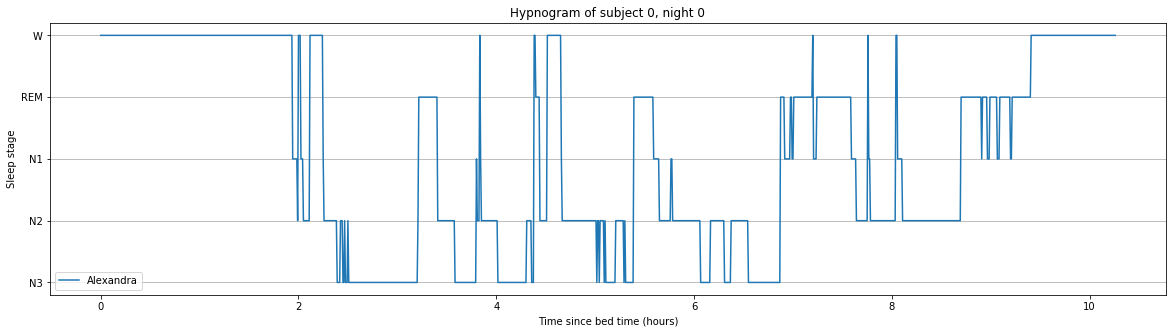

In [37]:
plt.rcParams["figure.figsize"] = (20,5)

print_hypnogram([y_openbci], ["Alexandra"], 0, 0)